In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

### Transforming state-wise industry breakdown employee data into Tableau readable format. Below code will:

### Collect 550+ CSV files containing employment data, transform it, and then save the transformed data into a single CSV file

In [3]:

def transform_file(file_path, state, industry):
    df = pd.read_csv(file_path)
    df = df.melt(id_vars=['Year'], var_name='Month', value_name='Number of Employed Persons')
    df['State'] = state
    df['Industry'] = industry
    return df

In [4]:

 base_folder = '/Users/alks/Downloads/DDA13/Python/capstone/data/cleaned_files/industry_state/'

all_data = []

for state_folder in os.listdir(base_folder):
    state_path = os.path.join(base_folder, state_folder)
    if os.path.isdir(state_path):

        for industry_file in os.listdir(state_path):
            file_path = os.path.join(state_path, industry_file)
            industry = industry_file.replace('.csv', '').split('_', 1)[1]  # Extract industry from file name
            state = state_folder
            # Transform the file and append the data
            transformed_df = transform_file(file_path, state, industry)
            all_data.append(transformed_df)

final_df = pd.concat(all_data, ignore_index=True)


### Cleaning final_df

In [6]:
final_df['State']=final_df['State'].str.replace("_"," ")

In [7]:
final_df['Industry'] = final_df['Industry'].replace(['mining,_logging_and_construction'], 'mining_logging_and_construction')

In [8]:
final_df['Industry'] = final_df['Industry'].replace(['trade,_transportation,_and_utilities'], 'trade_transportation_and_utilities')

In [9]:
final_df['State'] = final_df['State'].str.strip()

In [10]:
final_df['Year'] = final_df['Year'].astype(str)

In [11]:

final_df['State'] = final_df['State'].str.strip()
final_df['Industry'] = final_df['Industry'].str.strip()
final_df['Year'] = final_df['Year'].str.strip()


In [12]:
final_df['Date']=pd.to_datetime(final_df['Year'].astype(str) + final_df['Month'], format='%Y%b')

In [13]:
final_df['Number of Employed Persons'] = pd.to_numeric(final_df['Number of Employed Persons'], errors='coerce')

In [14]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79860 entries, 0 to 79859
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Year                        79860 non-null  object        
 1   Month                       79860 non-null  object        
 2   Number of Employed Persons  75625 non-null  float64       
 3   State                       79860 non-null  object        
 4   Industry                    79860 non-null  object        
 5   Date                        79860 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.7+ MB


In [15]:
final_df

,Year,Month,Number of Employed Persons,State,Industry,Date
0,2014,Jan,335.1,louisiana,government,2014-01-01
1,2015,Jan,330.5,louisiana,government,2015-01-01
2,2016,Jan,328.8,louisiana,government,2016-01-01
3,2017,Jan,330.4,louisiana,government,2017-01-01
4,2018,Jan,329.7,louisiana,government,2018-01-01
...,...,...,...,...,...,...
79855,2020,Dec,2627.2,california,professional_and_business_services,2020-12-01
79856,2021,Dec,2809.3,california,professional_and_business_services,2021-12-01
79857,2022,Dec,2838.8,california,professional_and_business_services,2022-12-01
79858,2023,Dec,2763.1,california,professional_and_business_services,2023-12-01


In [16]:
final_df.to_csv('/Users/alks/Downloads/DDA13/Python/capstone/data/cleaned_files/final_industry_state.csv', index=False)

### Creating dataset to group cumulative employment data by industry and date (not state)

In [18]:
grouped_indus_df = final_df.groupby(['Industry', 'Date','Month','Year']).sum().reset_index()


In [19]:
grouped_indus_df = grouped_indus_df.drop(columns='State')

In [20]:
grouped_indus_df

,Industry,Date,Month,Year,Number of Employed Persons
0,construction,2014-01-01,Jan,2014,5598.1
1,construction,2014-02-01,Feb,2014,5611.5
2,construction,2014-03-01,Mar,2014,5637.3
3,construction,2014-04-01,Apr,2014,5667.6
4,construction,2014-05-01,May,2014,5714.4
...,...,...,...,...,...
1711,trade_transportation_and_utilities,2024-08-01,Aug,2024,0.0
1712,trade_transportation_and_utilities,2024-09-01,Sep,2024,0.0
1713,trade_transportation_and_utilities,2024-10-01,Oct,2024,0.0
1714,trade_transportation_and_utilities,2024-11-01,Nov,2024,0.0


In [21]:
grouped_indus_df.to_csv('/Users/alks/Downloads/DDA13/Python/capstone/data/cleaned_files/grouped_indus_df.csv', index=False)

# Calculating number of months to recovery to pre-covid employment volumes by Industry

In [23]:
exclude_columns = ['Year', 'Month', 'Date']

selected_columns = [col for col in grouped_indus_df.columns if col not in exclude_columns]

In [24]:
df_pre_covid = grouped_indus_df.loc[grouped_indus_df['Date'] == '2020-01-01']

In [25]:
df_post_covid=grouped_indus_df.loc[grouped_indus_df['Date']>'2020-04-01']

In [26]:

# Function to calculate the difference in months
def diff_in_months(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

recovery_data = []
industries_met_condition = set()

for index, row in df_post_covid.iterrows():
    
    industry = row['Industry']
    
    if industry in industries_met_condition:
        continue
    
    pre_covid_value = df_pre_covid[df_pre_covid['Industry'] == industry]['Number of Employed Persons'].values[0]
    
    if row['Number of Employed Persons'] >= pre_covid_value:
        
        months_diff = diff_in_months(pd.to_datetime(row['Date']), pd.to_datetime('2020-04-01'))
    
        recovery_data.append((industry, row['Date'], months_diff))
        
        industries_met_condition.add(industry)

recovery_df = pd.DataFrame(recovery_data, columns=['Industry', 'Date', 'Months Until 2020-04-01'])

recovery_df = recovery_df[recovery_df['Industry'] != 'total_nonfarm']

In [27]:
recovery_df.to_csv('/Users/alks/Downloads/DDA13/Python/capstone/data/cleaned_files/recovery_df.csv', index=False)

### Creating a multi-dimensional correlation matrix between education attainment % per state and every industry per state

1. ### Creating a new column % of employed persons as 'emp_pct'

In [30]:
industry_avg=final_df.groupby(['State', 'Industry'])['Number of Employed Persons'].mean().reset_index(name='avg_employed_persons')

In [31]:
industry_total= industry_avg[
    industry_avg['Industry'] == 'total_nonfarm']


In [32]:
industry_total=industry_total.rename(columns={'avg_employed_persons': 'total_emp'})

In [33]:
pct_industry=pd.merge(industry_total, industry_avg, on='State', how='outer')

In [34]:
pct_industry['emp_pct']=((pct_industry['avg_employed_persons'])*100)/pct_industry['total_emp']

In [35]:
pct_industry.to_csv('pct_industry.csv', index=False)

2. ### Reading State-wise education data and creating new columns for High school diploma and Bachelor's degree which do not contain overlap data (With a High School Diploma or higher - Pct --> With a High School Diploma - Pct)

In [37]:
edu= pd.read_csv('/Users/alks/Downloads/DDA13/Python/capstone/data/cleaned_files/education_levels.csv')

In [38]:
edu["With a High School Diploma - Pct"] = edu["With a High School Diploma or higher - Pct"] - edu["With a Bachelor's Degree or higher - Pct"]
edu["With a Bachelor's Degree - Pct"] = edu["With a Bachelor's Degree or higher - Pct"] - edu["With an Advanced Degree - Pct"]

3. ### Creating the multi-dimensional correlation matrix

In [40]:
corr = {}

In [41]:
for edu_type in ['a High School Diploma', "a Bachelor's Degree", "an Advanced Degree"]:
    corr[edu_type] = {}
    for industry in list(set(pct_industry['Industry_y'])-set(["total_nonfarm"])):
        print(industry)
        filtered_df = pct_industry[
        (pct_industry['Industry_y'] == industry) 
    ]
    
        top_states_per_industry = (
            filtered_df
            .sort_values(by=['Industry_y', 'emp_pct'], ascending=[True, False])
            .groupby('Industry_y')
            .head(10)
            .reset_index(drop=True)
        )
        
        # Display the result
        merged_corr= pd.merge(top_states_per_industry, edu, on='State')
        corr[edu_type][industry] = merged_corr['emp_pct'].corr(merged_corr["With " + edu_type+" - Pct"])


government
financial_activities
manufacturing
other_services
trade_transportation_and_utilities
mining_and_logging
construction
professional_and_business_services
information
mining_logging_and_construction
private_education_and_health_services
leisure_and_hospitality
government
financial_activities
manufacturing
other_services
trade_transportation_and_utilities
mining_and_logging
construction
professional_and_business_services
information
mining_logging_and_construction
private_education_and_health_services
leisure_and_hospitality
government
financial_activities
manufacturing
other_services
trade_transportation_and_utilities
mining_and_logging
construction
professional_and_business_services
information
mining_logging_and_construction
private_education_and_health_services
leisure_and_hospitality


In [42]:
for edu_type in ['a High School Diploma', "a Bachelor's Degree", "an Advanced Degree"]:
    print(edu_type)
    corr_sorted = sorted(corr[edu_type], key = corr[edu_type].get)
    print([(x,corr[edu_type][x]) for x in corr_sorted])

a High School Diploma
[('private_education_and_health_services', -0.5878115140626016), ('professional_and_business_services', -0.44878781390330275), ('information', -0.2124749340336431), ('financial_activities', -0.15868770685914985), ('trade_transportation_and_utilities', -0.06866618628100869), ('mining_logging_and_construction', 0.0060045162868224), ('leisure_and_hospitality', 0.14319134466299294), ('manufacturing', 0.2697599086854733), ('government', 0.3393455795289681), ('other_services', 0.5485440758842967), ('mining_and_logging', 0.5681982239046255), ('construction', 0.671000164322886)]
a Bachelor's Degree
[('construction', -0.5348402570479078), ('other_services', -0.38326135896757046), ('financial_activities', -0.21467075893612741), ('government', -0.09996359106413825), ('leisure_and_hospitality', -0.058501818535666425), ('mining_and_logging', 0.05572355749477165), ('private_education_and_health_services', 0.07356006840297044), ('manufacturing', 0.30050962282422194), ('trade_tra

In [43]:
pct_industry.head()

,State,Industry_x,total_emp,Industry_y,avg_employed_persons,emp_pct
0,alabama,total_nonfarm,2043.6872,construction,90.6144,4.433868
1,alabama,total_nonfarm,2043.6872,financial_activities,97.9816,4.794354
2,alabama,total_nonfarm,2043.6872,government,388.0536,18.987916
3,alabama,total_nonfarm,2043.6872,information,21.4456,1.049358
4,alabama,total_nonfarm,2043.6872,leisure_and_hospitality,196.1624,9.598455


In [44]:
pct_industry = pct_industry.drop(pct_industry[pct_industry['Industry_y'] == 'mining_logging_and_construction'].index)

In [45]:
set(pct_industry['Industry_y'])-set(["total_nonfarm"])

{'construction',
 'financial_activities',
 'government',
 'information',
 'leisure_and_hospitality',
 'manufacturing',
 'mining_and_logging',
 'other_services',
 'private_education_and_health_services',
 'professional_and_business_services',
 'trade_transportation_and_utilities'}

In [46]:
import numpy as np
edu_type_list = ['a High School Diploma', "a Bachelor's Degree", "an Advanced Degree"]
corr_matrix = np.array([[corr[edu_type][ind] for edu_type in edu_type_list] for ind in sorted(corr[edu_type_list[0]])])
corr_matrix.shape

(12, 3)

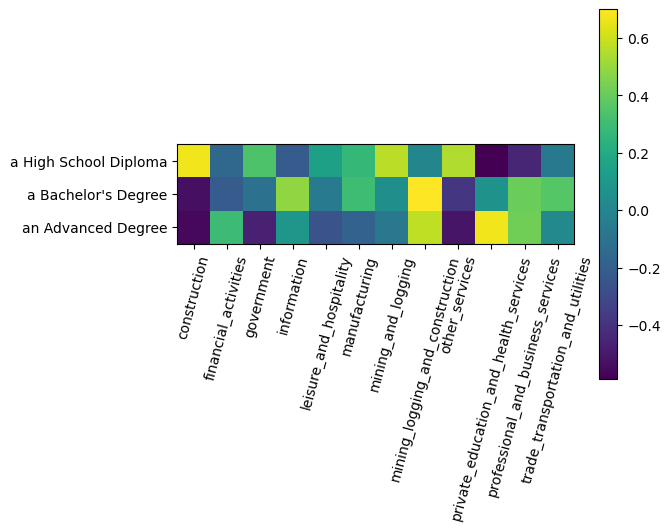

In [47]:
plt.figure()
plt.imshow(corr_matrix.T)
plt.xticks(ticks = np.arange(corr_matrix.shape[0]), labels = sorted(corr[edu_type_list[0]]),rotation = 75)
plt.yticks(ticks = np.arange(corr_matrix.shape[1]), labels = edu_type_list)
plt.colorbar()
plt.savefig('/Users/alks/Downloads/DDA13/Python/capstone/data/cleaned_files/plot.png', bbox_inches='tight')